# Quadrotor transportation

## System dynamics

### State variables

In [1]:
from flax import struct
from jax import numpy as jnp

@struct.dataclass
class EnvState:
    y: float
    z: float
    theta: float
    phi: float
    y_dot: float
    z_dot: float
    theta_dot: float
    phi_dot: float
    last_thrust: float  # Only needed for rendering
    last_tau: float  # Only needed for rendering
    time: int
    y_traj: jnp.ndarray
    z_traj: jnp.ndarray
    y_dot_traj: jnp.ndarray
    z_dot_traj: jnp.ndarray
    y_tar: float
    z_tar: float
    y_dot_tar: float
    z_dot_tar: float
    y_hook: float
    z_hook: float
    y_hook_dot: float
    z_hook_dot: float
    y_obj: float
    z_obj: float
    y_obj_dot: float
    z_obj_dot: float
    f_rope: float
    f_rope_y: float
    f_rope_z: float
    l_rope: float


@struct.dataclass
class EnvParams:
    max_speed: float = 8.0
    max_torque: float = 0.012
    max_thrust: float = 0.8
    dt: float = 0.02
    g: float = 9.81  # gravity
    m: float = 0.03  # mass
    I: float = 2.0e-5  # moment of inertia
    mo: float = 0.005  # mass of the object attached to the rod
    l: float = 0.3  # length of the rod
    delta_yh: float = 0.03  # y displacement of the hook from the quadrotor center
    delta_zh: float = -0.06  # z displacement of the hook from the quadrotor center
    max_steps_in_episode: int = 300
    rope_taut_therehold: float = 1e-4

@struct.dataclass
class Action:
    thrust: float
    tau: float

def angle_normalize(x: float) -> float:
    """Normalize the angle - radians."""
    return ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi

/home/pcy/miniconda3/envs/jax/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


### Taut dynamics

In [2]:
import sympy as sp
from sympy.physics.mechanics import (
    dynamicsymbols,
    ReferenceFrame,
    Point,
    Particle,
    RigidBody,
    inertia,
)
from jax import numpy as jnp    
from functools import partial

# Define symbols
t = sp.Symbol("t")  # time
m = sp.Symbol("m", positive=True)  # mass of the quadrotor
I = sp.Symbol("I", positive=True)  # moment of inertia
g = sp.Symbol("g", positive=True)  # gravitational acceleration
l = sp.Symbol("l", positive=True)  # length of the rod
mo = sp.Symbol("mo", positive=True)  # mass of the object attached to the rod
thrust = sp.Function("thrust")(t)  # thrust force
tau = sp.Function("tau")(t)  # torque
f_rope = sp.Symbol("f_rope")  # force in the rope
delta_yh = sp.Symbol("delta_yh")  # y displacement of the hook from the quadrotor center
delta_zh = sp.Symbol("delta_zh")  # z displacement of the hook from the quadrotor center
params = [m, I, g, l, mo, delta_yh, delta_zh]
action = [thrust, tau]

# Define state variables and their derivatives
y, z, theta, phi = dynamicsymbols("y z theta phi")
y_dot, z_dot, theta_dot, phi_dot = sp.diff(y, t), sp.diff(z, t), sp.diff(theta, t), sp.diff(phi, t)
y_ddot, z_ddot, theta_ddot, phi_ddot = sp.diff(y_dot, t), sp.diff(z_dot, t), sp.diff(theta_dot, t), sp.diff(phi_dot, t)
y_dot_val, z_dot_val, theta_dot_val, phi_dot_val = sp.symbols("y_dot_val z_dot_val theta_dot_val phi_dot_val")
y_ddot_val, z_ddot_val, theta_ddot_val, phi_ddot_val = sp.symbols("y_ddot_val z_ddot_val theta_ddot_val phi_ddot_val")
states = [y, z, theta, phi, y_dot, z_dot, theta_dot, phi_dot]
states_val = [y, z, theta, phi, y_dot_val, z_dot_val, theta_dot_val, phi_dot_val]
states_dot = [y_ddot, z_ddot, theta_ddot, phi_ddot, f_rope]
states_dot_val = [y_ddot_val, z_ddot_val, theta_ddot_val, phi_ddot_val, f_rope]

# intermediate variables
delta_yh_global = delta_yh * sp.cos(theta) - delta_zh * sp.sin(theta)
delta_zh_global = delta_yh * sp.sin(theta) + delta_zh * sp.cos(theta)
f_rope_y = f_rope * sp.sin(theta+phi)
f_rope_z = -f_rope * sp.cos(theta+phi)
y_hook = y + delta_yh_global
z_hook = z + delta_zh_global
y_hook_dot = sp.diff(y_hook, t)
z_hook_dot = sp.diff(z_hook, t)
y_obj = y_hook + l * sp.sin(theta+phi)
z_obj = z_hook - l * sp.cos(theta+phi)
y_obj_dot = sp.diff(y_obj, t)
z_obj_dot = sp.diff(z_obj, t)
y_obj_ddot = sp.diff(y_obj_dot, t)
z_obj_ddot = sp.diff(z_obj_dot, t)
obses = [y_obj, z_obj, y_obj_dot, z_obj_dot, y_obj_ddot, z_obj_ddot, f_rope_y, f_rope_z]

# Define inertial reference frame
N = ReferenceFrame("N")
N_origin = Point('N_origin')
A = N.orientnew("A", "Axis", [theta, N.x])
B = A.orientnew("B", "Axis", [phi, A.x])

# Define point
drone = Point("drone")
drone.set_pos(N_origin, y * N.y + z * N.z)
hook = drone.locatenew("hook", delta_yh * A.y + delta_zh * A.z)
obj = hook.locatenew("obj", -l * B.z)
drone.set_vel(N, y_dot * N.y + z_dot * N.z)

# Inertia
inertia_quadrotor = inertia(N, I, 0, 0)
quadrotor = RigidBody("quadrotor", drone, A, m, (inertia_quadrotor, drone))
obj_particle = Particle("obj_particle", obj, mo)

# Newton's law
eq_quad_y = -thrust * sp.sin(theta) + f_rope_y - m * y_ddot
eq_quad_z = thrust * sp.cos(theta) + f_rope_z - m * g - m * z_ddot
eq_quad_theta = tau + delta_yh_global * f_rope_z - delta_zh_global * f_rope_y - I * theta_ddot
eq_obj_y = -f_rope_y - mo * y_obj_ddot
eq_obj_z = -f_rope_z - mo * g - mo * z_obj_ddot

eqs = [eq_quad_y, eq_quad_z, eq_quad_theta, eq_obj_y, eq_obj_z]
eqs = [eq.expand() for eq in eqs]
eqs = [eq.subs([(states_dot[i], states_dot_val[i]) for i in range(len(states_dot))]) for eq in eqs]
eqs = [eq.subs([(states[i], states_val[i]) for i in range(len(states))]) for eq in eqs]
# Solve for the acceleration
A_taut_dyn = sp.zeros(5, 5)
b_taut_dyn = sp.zeros(5, 1)
for i in range(5):
    for j in range(5):
        A_taut_dyn[i, j] = eqs[i].coeff(states_dot_val[j])
    b_taut_dyn[i] = -eqs[i].subs([(states_dot_val[j], 0) for j in range(5)])
# lambda A_taut_dyn
A_taut_dyn_func = sp.lambdify(params + states_val + action, A_taut_dyn, "jax")
b_taut_dyn_func = sp.lambdify(params + states_val + action, b_taut_dyn, "jax")

# Solve for observation
obs_eqs = [y_obj, z_obj, y_obj_dot, z_obj_dot, y_hook, z_hook, y_hook_dot, z_hook_dot, f_rope_y, f_rope_z]
# replace states with states_val, states_dot with states_dot_val
obs_eqs = [eq.subs([(states_dot[i], states_dot_val[i]) for i in range(len(states_dot))]) for eq in obs_eqs]
obs_eqs = [eq.subs([(states[i], states_val[i]) for i in range(len(states))]) for eq in obs_eqs]
# lambda obs_eqs
obs_eqs_func = sp.lambdify(params + states_val + states_dot_val + action, obs_eqs, "jax")
# lambda some other obs functions
y_hook_func = sp.lambdify(params + states_val, obs_eqs[4], "jax")
z_hook_func = sp.lambdify(params + states_val, obs_eqs[5], "jax")
y_hook_dot_func = sp.lambdify(params + states_val, obs_eqs[6], "jax")
z_hook_dot_func = sp.lambdify(params + states_val, obs_eqs[7], "jax")

# dynamics (params, states) -> states_dot
def taut_dynamics(env_params:EnvParams, env_state:EnvState, env_action:Action):
    params = [env_params.m, env_params.I, env_params.g, env_params.l, env_params.mo, env_params.delta_yh, env_params.delta_zh]
    states = [env_state.y, env_state.z, env_state.theta, env_state.phi, env_state.y_dot, env_state.z_dot, env_state.theta_dot, env_state.phi_dot]
    action = [env_action.thrust, env_action.tau]
    A = A_taut_dyn_func(*params, *states, *action)
    b = b_taut_dyn_func(*params, *states, *action)
    states_dot = jnp.linalg.solve(A, b).squeeze()
    y_ddot, z_ddot, theta_ddot, phi_ddot, f_rope = states_dot

    # Calculate updated state variables
    new_y_dot = env_state.y_dot + y_ddot * env_params.dt
    new_z_dot = env_state.z_dot + z_ddot * env_params.dt
    new_theta_dot = env_state.theta_dot + theta_ddot * env_params.dt
    new_phi_dot = env_state.phi_dot + phi_ddot * env_params.dt
    new_y = env_state.y + new_y_dot * env_params.dt
    new_z = env_state.z + new_z_dot * env_params.dt
    new_theta = angle_normalize(env_state.theta + new_theta_dot * env_params.dt)
    new_phi = angle_normalize(env_state.phi + new_phi_dot * env_params.dt)

    # Update states list
    states = [new_y, new_z, new_theta, new_phi, new_y_dot, new_z_dot, new_theta_dot, new_phi_dot]

    # Compute other state variables
    y_obj, z_obj, y_obj_dot, z_obj_dot, y_hook, z_hook, y_hook_dot, z_hook_dot, f_rope_y, f_rope_z = obs_eqs_func(*params, *states, *states_dot, *action)

    # Update all state variables at once using replace()
    env_state = env_state.replace(
        y=new_y,
        z=new_z,
        theta=new_theta,
        phi=new_phi,
        y_dot=new_y_dot,
        z_dot=new_z_dot,
        theta_dot=new_theta_dot,
        phi_dot=new_phi_dot,
        y_obj=y_obj,
        z_obj=z_obj,
        y_obj_dot=y_obj_dot,
        z_obj_dot=z_obj_dot,
        y_hook=y_hook,
        z_hook=z_hook,
        y_hook_dot=y_hook_dot,
        z_hook_dot=z_hook_dot,
        f_rope_y=f_rope_y,
        f_rope_z=f_rope_z,
        f_rope=f_rope,
        l_rope=env_params.l,
        last_thrust=env_action.thrust,
        last_tau=env_action.tau,
        time=env_state.time + 1,
        y_tar=env_state.y_traj[env_state.time],
        z_tar=env_state.z_traj[env_state.time],
        y_dot_tar=env_state.y_dot_traj[env_state.time],
        z_dot_tar=env_state.z_dot_traj[env_state.time],
    )

    return env_state

### Loose Dynamics

In [3]:
# dynamics (params, states) -> states_dot
def loose_dynamics(env_params:EnvParams, env_state:EnvState, env_action:Action):
    params = [env_params.m, env_params.I, env_params.g, env_params.l, env_params.mo, env_params.delta_yh, env_params.delta_zh]
    states = [env_state.y, env_state.z, env_state.theta, env_state.phi, env_state.y_dot, env_state.z_dot, env_state.theta_dot, env_state.phi_dot]
    action = [env_action.thrust, env_action.tau]

    y_ddot = -env_action.thrust * jnp.sin(env_state.theta) / env_params.m
    z_ddot = env_action.thrust * jnp.cos(env_state.theta) / env_params.m - env_params.g
    theta_ddot = env_action.tau / env_params.I

    new_y_dot = env_state.y_dot + env_params.dt * y_ddot
    new_z_dot = env_state.z_dot + env_params.dt * z_ddot
    new_theta_dot = env_state.theta_dot + env_params.dt * theta_ddot
    new_y = env_state.y + env_params.dt * new_y_dot
    new_z = env_state.z + env_params.dt * new_z_dot
    new_theta = angle_normalize(env_state.theta + env_params.dt * new_theta_dot)

    states = [new_y, new_z, new_theta, env_state.phi, new_y_dot, new_z_dot, new_theta_dot, env_state.phi_dot]

    y_hook = y_hook_func(*params, *states)
    z_hook = z_hook_func(*params, *states)
    y_hook_dot = y_hook_dot_func(*params, *states)
    z_hook_dot = z_hook_dot_func(*params, *states)

    new_y_obj_dot = env_state.y_obj_dot
    new_z_obj_dot = env_state.z_obj_dot - env_params.g * env_params.dt
    new_y_obj = env_state.y_obj + env_params.dt * new_y_obj_dot
    new_z_obj = env_state.z_obj + env_params.dt * new_z_obj_dot

    phi_th = -jnp.arctan2(y_hook - new_y_obj, z_hook - new_z_obj)
    new_phi = angle_normalize(phi_th - new_theta)

    y_obj2hook_dot = new_y_obj_dot - y_hook_dot
    z_obj2hook_dot = new_z_obj_dot - z_hook_dot
    phi_th_dot = y_obj2hook_dot * jnp.cos(phi_th) + z_obj2hook_dot * jnp.sin(phi_th)
    new_phi_dot = phi_th_dot - new_theta_dot

    new_l_rope = jnp.sqrt((y_hook - new_y_obj) ** 2 + (z_hook - new_z_obj) ** 2)

    env_state = env_state.replace(
        y=new_y,
        z=new_z,
        theta=new_theta,
        phi=new_phi,
        y_dot=new_y_dot,
        z_dot=new_z_dot,
        theta_dot=new_theta_dot,
        phi_dot=new_phi_dot,
        y_hook=y_hook,
        z_hook=z_hook,
        y_hook_dot=y_hook_dot,
        z_hook_dot=z_hook_dot,
        y_obj=new_y_obj,
        z_obj=new_z_obj,
        y_obj_dot=new_y_obj_dot,
        z_obj_dot=new_z_obj_dot,
        l_rope=new_l_rope,
        f_rope=0.0,
        f_rope_y=0.0,
        f_rope_z=0.0,
        last_thrust=env_action.thrust,
        last_tau=env_action.tau,
        time=env_state.time + 1,
        y_tar=env_state.y_traj[env_state.time],
        z_tar=env_state.z_traj[env_state.time],
        y_dot_tar=env_state.y_dot_traj[env_state.time],
        z_dot_tar=env_state.z_dot_traj[env_state.time],
    )

    return env_state

### Transfer dynamics

In [4]:
import sympy as sp

# Define the variables
I, m, l, mo, delta_yh, delta_zh, Imp, t = \
    sp.symbols('I m l mo delta_yh delta_zh Imp t')
theta, phi, y, z, \
    loose_y_dot, loose_z_dot, loose_theta_dot, loose_y_obj_dot, loose_z_obj_dot, \
    taut_y_dot, taut_z_dot, taut_theta_dot, taut_phi_dot = \
    sp.symbols('theta phi y z \
                    loose_y_dot loose_z_dot loose_theta_dot loose_y_obj_dot loose_z_obj_dot \
                    taut_y_dot taut_z_dot taut_theta_dot taut_phi_dot')

# Define velocities
# get the linear velocity of the object in the world frame
taut_xyz_obj_dot = sp.Matrix([0,taut_y_dot, taut_z_dot]) + \
                     sp.Matrix([taut_theta_dot,0,0]).cross(sp.Matrix([0,delta_yh * sp.cos(theta) - delta_zh * sp.sin(theta), delta_yh * sp.sin(theta) + delta_zh * sp.cos(theta)])) + \
                        sp.Matrix([taut_phi_dot+taut_theta_dot, 0,0]).cross(sp.Matrix([0,l * sp.sin(phi+theta), -l * sp.cos(phi+theta)])) 
taut_y_obj_dot, taut_z_obj_dot = taut_xyz_obj_dot[1], taut_xyz_obj_dot[2]

# linear momentum balance for the quadrotor
lin_quad_y = m * loose_y_dot + Imp * sp.sin(theta+phi) - m * taut_y_dot
lin_quad_z = m * loose_z_dot - Imp * sp.cos(theta+phi) - m * taut_z_dot

# linear momentum balance for the object
lin_obj_y = sp.expand(mo * loose_y_obj_dot - Imp * sp.sin(theta+phi) - mo * taut_y_obj_dot)
lin_obj_z = sp.expand(mo * loose_z_obj_dot + Imp * sp.cos(theta+phi) - mo * taut_z_obj_dot)

# angular momentum balance for the quadrotor
M = delta_yh * (- Imp * sp.cos(phi+theta)) - delta_zh * (Imp * sp.sin(phi+theta))
ang_quad = I * loose_theta_dot + M - I * taut_theta_dot

equations = [lin_quad_y, lin_quad_z, lin_obj_y, lin_obj_z, ang_quad]
num_equations = len(equations)
taut_state = [taut_y_dot, taut_z_dot, taut_theta_dot, taut_phi_dot, Imp]

Atrans = sp.Matrix(num_equations, len(taut_state), lambda i, j: equations[i].coeff(taut_state[j]))
btrans = -sp.Matrix(num_equations, 1, lambda i, j: equations[i].subs([(var, 0) for var in taut_state]))

params = [I, m, l, mo, delta_yh, delta_zh]
loose_state = [theta, phi, y, z, loose_y_dot, loose_z_dot, loose_theta_dot, loose_y_obj_dot, loose_z_obj_dot]

# lambdify the matrix
Atrans_func = sp.lambdify(params+loose_state, Atrans, modules='jax')
btrans_func = sp.lambdify(params+loose_state, btrans, modules='jax')

# Define the function to compute A^-1 (x-b)
def loose2taut_transfer(env_params: EnvParams, loose_state: EnvState, loose2taut:bool):
    params = [env_params.I, env_params.m, env_params.l, env_params.mo, env_params.delta_yh, env_params.delta_zh]
    loose_state_values = [loose_state.theta, loose_state.phi, loose_state.y, loose_state.z, loose_state.y_dot, loose_state.z_dot, loose_state.theta_dot, loose_state.y_obj_dot, loose_state.z_obj_dot]
    A_val = Atrans_func(*params, *loose_state_values)
    b_val = btrans_func(*params, *loose_state_values)
    taut_y_dot, taut_z_dot, taut_theta_dot, taut_phi_dot, Imp = jnp.linalg.solve(A_val, b_val).squeeze()

    new_y_dot = taut_y_dot * loose2taut + loose_state.y_dot * (1 - loose2taut)
    new_z_dot = taut_z_dot * loose2taut + loose_state.z_dot * (1 - loose2taut)
    new_theta_dot = taut_theta_dot * loose2taut + loose_state.theta_dot * (1 - loose2taut)
    new_phi_dot = taut_phi_dot * loose2taut + loose_state.phi_dot * (1 - loose2taut)
    new_l_rope = env_params.l * loose2taut + loose_state.l_rope * (1 - loose2taut)

    loose_state = loose_state.replace(
        y_dot=new_y_dot,
        z_dot=new_z_dot,
        theta_dot=new_theta_dot,
        phi_dot=new_phi_dot,
        l_rope=new_l_rope
    )

    return loose_state

def dynamic_transfer(env_params:EnvParams, loose_state:EnvState, taut_state:EnvState, old_loose_state:bool):
    new_loose_state = loose_state.l_rope < (env_params.l - env_params.rope_taut_therehold)
    taut2loose = (taut_state.f_rope < 0.0) & (~old_loose_state)
    loose2taut = (~new_loose_state) & (old_loose_state)

    # taut2loose dynamics
    new_taut_l_rope = taut_state.l_rope - taut2loose * env_params.rope_taut_therehold * 2.0
    taut_state = taut_state.replace(l_rope=new_taut_l_rope)

    # loose2taut dynamics
    loose_state = loose2taut_transfer(env_params, loose_state, loose2taut)

    # use loose_state when old_loose_state is True, else use taut_state
    new_state = {}
    for k in loose_state.__dict__.keys():
        new_state[k] = jnp.where(old_loose_state, loose_state.__dict__[k], taut_state.__dict__[k])

    loose_state = loose_state.replace(**new_state)

    return loose_state

## Environment definition

### Define environment

In [5]:
import jax
import jax.numpy as jnp
from jax import lax
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
import chex
from flax import struct

class Quad2D(environment.Environment):
    """
    JAX Compatible version of Quad2D-v0 OpenAI gym environment. Source:
    github.com/openai/gym/blob/master/gym/envs/classic_control/Quad2D.py
    """

    def __init__(self):
        super().__init__()
        self.obs_shape = (24,)

    @property
    def default_params(self) -> EnvParams:
        """Default environment parameters for Quad2D-v0."""
        return EnvParams()
    
    def step_env(
        self,
        key: chex.PRNGKey,
        state: EnvState,
        action: float,
        params: EnvParams,
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        thrust = (action[0] + 1.0) / 2.0 * params.max_thrust
        tau = action[1] * params.max_torque
        reward = 1.0 - (
            0.8
            * jnp.sqrt(
                (state.y_tar - state.y_obj) ** 2 + (state.z_tar - state.z_obj) ** 2
            )  # close to center
            + 0.03
            * jnp.sqrt(
                (state.y_dot_tar - state.y_obj_dot) ** 2
                + (state.z_dot_tar - state.z_obj_dot) ** 2
            )  # zero velocity
        )
        reward = reward.squeeze()
        env_action = Action(thrust=thrust, tau=tau)

        old_loose_state = state.l_rope < (params.l - params.rope_taut_therehold)
        taut_state = taut_dynamics(params, state, env_action)
        loose_state = loose_dynamics(params, state, env_action)
        new_state = dynamic_transfer(params, loose_state, taut_state, old_loose_state)

        done = self.is_terminal(state, params)
        return (
            lax.stop_gradient(self.get_obs(new_state)),
            lax.stop_gradient(new_state),
            reward,
            done,
            {"discount": self.discount(new_state, params)},
        )

    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Reset environment state by sampling theta, theta_dot."""
        # generate reference trajectory by adding a few sinusoids together
        y_traj, z_traj, y_dot_traj, z_dot_traj = self.generate_traj(key)

        high = jnp.array([1, 1, jnp.pi / 3])
        y, z, theta = jax.random.uniform(key, shape=(3,), minval=-high, maxval=high)
        y_hook = y + params.delta_yh * jnp.cos(theta) - params.delta_zh * jnp.sin(theta) 
        z_hook = z + params.delta_yh * jnp.sin(theta) + params.delta_zh * jnp.cos(theta)
        state = EnvState(
            y=y, z=z, theta=theta, 
            y_dot=0.0, z_dot=0.0, theta_dot=0.0,last_thrust=0.0,last_tau=0.0,time=0,
            y_traj=y_traj,z_traj=z_traj,y_dot_traj=y_dot_traj,z_dot_traj=z_dot_traj,y_tar=y_traj[0],z_tar=z_traj[0],y_dot_tar=y_dot_traj[0],z_dot_tar=z_dot_traj[0],
            phi=0.0,phi_dot=0.0,
            y_hook=y_hook,z_hook=z_hook,y_hook_dot=0.0,z_hook_dot=0.0,
            y_obj=y_hook + params.l * jnp.sin(theta), z_obj = z_hook - params.l * jnp.cos(theta), y_obj_dot=0.0, z_obj_dot=0.0,
            f_rope=0.0, f_rope_y=0.0, f_rope_z=0.0,l_rope=params.l,
        )
        return self.get_obs(state), state
    
    @partial(jax.jit, static_argnums=(0,))
    def sample_params(self, key: chex.PRNGKey) -> EnvParams:
        """Sample environment parameters."""
        
        key, key1, key2, key3, key4, key5, key6 = jax.random.split(key, 7)
        
        m = jax.random.uniform(key1, shape=(), minval=0.025, maxval=0.04)
        I = jax.random.uniform(key2, shape=(), minval=2.5e-5, maxval=3.5e-5)
        mo = jax.random.uniform(key3, shape=(), minval=0.003, maxval=0.01)
        l = jax.random.uniform(key4, shape=(), minval=0.2, maxval=0.4)
        delta_yh = jax.random.uniform(key5, shape=(), minval=-0.04, maxval=0.04)
        delta_zh = jax.random.uniform(key6, shape=(), minval=0.0, maxval=0.06)
        
        return EnvParams(m=m, I=I, mo=mo, l=l, delta_yh=delta_yh, delta_zh=delta_zh)

    def generate_traj(self, key: chex.PRNGKey) -> chex.Array:
        # get random attitude and phase
        key_amp_y, key_phase_y, key_amp_z, key_phase_z = jax.random.split(key, 4)
        rand_amp_y = jax.random.uniform(key_amp_y, shape=(2,), minval=-1.0, maxval=1.0)
        rand_amp_z = jax.random.uniform(key_amp_z, shape=(2,), minval=-1.0, maxval=1.0)
        rand_phase_y = jax.random.uniform(
            key_phase_y, shape=(2,), minval=-jnp.pi, maxval=jnp.pi
        )
        rand_phase_z = jax.random.uniform(
            key_phase_z, shape=(2,), minval=-jnp.pi, maxval=jnp.pi
        )
        # get trajectory
        scale = 0.8
        ts = jnp.arange(
            0, self.default_params.max_steps_in_episode, self.default_params.dt
        )  # NOTE: do not use params for jax limitation
        w1 = 2 * jnp.pi * 0.25
        w2 = 2 * jnp.pi * 0.5
        y_traj = scale * rand_amp_y[0] * jnp.sin(
            w1 * ts + rand_phase_y[0]
        ) + scale * rand_amp_y[1] * jnp.sin(w2 * ts + rand_phase_y[1])
        z_traj = scale * rand_amp_z[0] * jnp.sin(
            w1 * ts + rand_phase_z[0]
        ) + scale * rand_amp_z[1] * jnp.sin(w2 * ts + rand_phase_z[1])
        y_dot_traj = scale * rand_amp_y[0] * w1 * jnp.cos(
            w1 * ts + rand_phase_y[0]
        ) + scale * rand_amp_y[1] * w2 * jnp.cos(w2 * ts + rand_phase_y[1])
        z_dot_traj = scale * rand_amp_z[0] * w1 * jnp.cos(
            w1 * ts + rand_phase_z[0]
        ) + scale * rand_amp_z[1] * w2 * jnp.cos(w2 * ts + rand_phase_z[1])
        return y_traj, z_traj, y_dot_traj, z_dot_traj

    def get_obs(self, state: EnvState) -> chex.Array:
        """Return angle in polar coordinates and change."""
        
        obs_elements = [
            state.y,
            state.z,
            state.theta,
            state.y_dot / 4.0,
            state.z_dot / 4.0,
            state.theta_dot / 40.0,
            state.y_tar,
            state.z_tar,
            state.y_dot_tar / 4.0,
            state.z_dot_tar / 4.0,
            state.y_tar - state.y,
            state.z_tar - state.z,
            (state.y_dot_tar - state.y_dot) / 4.0,
            (state.z_dot_tar - state.z_dot) / 4.0,
            state.phi,
            state.phi_dot / 10.0,
            state.y_obj,
            state.z_obj,
            state.y_obj_dot / 4.0,
            state.z_obj_dot / 4.0,
            state.y_hook,
            state.z_hook,
            state.y_hook_dot / 4.0,
            state.z_hook_dot / 4.0,
        ]
        
        # Debug print
        # for i, elem in enumerate(obs_elements):
        #     print(f"Element {i}: shape {jax.numpy.shape(elem)}")
        
        return jnp.array(obs_elements).squeeze()

    def is_terminal(self, state: EnvState, params: EnvParams) -> bool:
        """Check whether state is terminal."""
        # Check number of steps in episode termination condition
        done = (
            (state.time >= params.max_steps_in_episode)
            | (jnp.abs(state.y) > 2.0)
            | (jnp.abs(state.z) > 2.0)
            | (jnp.abs(state.theta_dot) > 100.0)
            | (jnp.abs(state.phi_dot) > 100.0)
        )
        return done

    @property
    def name(self) -> str:
        """Environment name."""
        return "Quad2D-v1"

    @property
    def num_actions(self) -> int:
        """Number of actions possible in environment."""
        return 2

    def action_space(self, params: Optional[EnvParams] = None) -> spaces.Box:
        """Action space of the environment."""
        if params is None:
            params = self.default_params
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(2,),
            dtype=jnp.float32,
        )

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        return spaces.Box(-1.0, 1.0, shape=(24,), dtype=jnp.float32)

    def state_space(self, params: EnvParams) -> spaces.Dict:
        """State space of the environment."""
        return spaces.Dict(
            {
                "y": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "z": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "y_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "z_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "theta": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "theta_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "last_thrust": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "last_tau": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "time": spaces.Discrete(params.max_steps_in_episode),
            }
        )


def angle_normalize(x: float) -> float:
    """Normalize the angle - radians."""
    return ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi

### test function

In [48]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def test_env(env: Quad2D, policy, render_video=False):
    rng = jax.random.PRNGKey(1)
    rng, rng_params = jax.random.split(rng)
    env_params = env.sample_params(rng_params)
    # env_params = env.default_params

    state_seq, obs_seq, reward_seq = [], [], []
    rng, rng_reset = jax.random.split(rng)
    obs, env_state = env.reset(rng_reset, env_params)
    n_dones = 0
    while True:
        state_seq.append(env_state)
        rng, rng_act, rng_step = jax.random.split(rng, 3)
        action = policy(obs, rng_act)
        next_obs, next_env_state, reward, done, info = env.step(
            rng_step, env_state, action, env_params
        )
        if done:
            rng, rng_params = jax.random.split(rng)
            env_params = env.sample_params(rng_params)
        reward_seq.append(reward)
        obs_seq.append(obs)
        if done:
            n_dones += 1
        obs = next_obs
        env_state = next_env_state
        if n_dones >= 1:
            break

    # plot trajectory
    def update_plot(frame_num):
        plt.gca().clear()
        frame_list = np.arange(np.max([0, frame_num - 100]), frame_num + 1)
        plt.plot([s.y_obj for s in state_seq[frame_list[0]:frame_list[-1]]], [s.z_obj for s in state_seq[frame_list[0]:frame_list[-1]]], alpha=0.5)
        plt.plot([s.y_tar for s in state_seq[frame_list[0]:frame_list[-1]]], [s.z_tar for s in state_seq[frame_list[0]:frame_list[-1]]], "--", alpha=0.3)
        
        start = max(0, frame_num)
        for i in range(start, frame_num + 1):
            num_steps = max(frame_num - start, 1)
            alpha = 1 if i == frame_num else ((i-start) / num_steps * 0.1)
            plt.arrow(
                state_seq[i].y,
                state_seq[i].z,
                -0.1 * jnp.sin(state_seq[i].theta),
                0.1 * jnp.cos(state_seq[i].theta),
                width=0.01,
                color="b",
                alpha=alpha,
            )
            # plot object as point
            plt.plot(state_seq[i].y_obj, state_seq[i].z_obj, "o", color="b", alpha=alpha)
            # plot hook as cross
            plt.plot(state_seq[i].y_hook, state_seq[i].z_hook, "x", color="r", alpha=alpha)
            plt.arrow(
                state_seq[i].y_hook,
                state_seq[i].z_hook,
                state_seq[i].y_obj - state_seq[i].y_hook,
                state_seq[i].z_obj - state_seq[i].z_hook,
                width=0.01,
                color="r" if state_seq[i].l_rope > (env_params.l - env_params.rope_taut_therehold) else "g",
                alpha=alpha,
            )
            # plot y_tar and z_tar with red dot
            plt.plot(state_seq[i].y_tar, state_seq[i].z_tar, "ro", alpha=alpha)
        plt.xlabel("y")
        plt.ylabel("z")
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])

    if render_video:
        plt.figure(figsize=(4, 4))
        anim = FuncAnimation(plt.gcf(), update_plot, frames=len(state_seq), interval=20)
        anim.save(filename="../results/anim.gif", writer="imagemagick", fps=int(1.0/env_params.dt))

    num_figs = len(state_seq[0].__dict__) + 2
    time = [s.time * env_params.dt for s in state_seq]

    # calculate number of rows needed
    num_rows = int(jnp.ceil(num_figs / 6))

    # create num_figs subplots
    plt.subplots(num_rows, 6, figsize=(4 * 6, 2 * num_rows))

    # plot reward
    plt.subplot(num_rows, 6, 1)
    plt.plot(time, reward_seq)
    plt.ylabel("reward")

    # plot obs
    plt.subplot(num_rows, 6, 2)
    for i in range(len(obs_seq[0])):
        plt.plot(time, [o[i] for o in obs_seq], label=f"obs[{i}]")
    plt.ylabel("obs")
    plt.legend(fontsize=3)

    # plot state
    current_fig = 3
    for i, (name, value) in enumerate(state_seq[0].__dict__.items()):
        if name in ["y_traj", "z_traj", "y_dot_traj", "z_dot_traj", "theta_traj"]:
            continue
        current_fig += 1
        plt.subplot(num_rows, 6, current_fig)
        plt.plot(time, [getattr(s, name) for s in state_seq])
        if name in ["y", "z", "y_dot", "z_dot"]:
            plt.plot(time, [s.__dict__[name + "_tar"] for s in state_seq], "--")
            plt.legend(["actual", "target"], fontsize=3)
        plt.ylabel(name)

    plt.xlabel("time")
    plt.tight_layout()
    plt.savefig("../results/plot.png")
    plt.show()

### run PID policy to test

MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_789196/1876414554.py:38: RuntimeWarning: invalid value encountered in true_divide
  alphas = (frame_list - frame_list[0]) / (frame_list[-1] - frame_list[0])


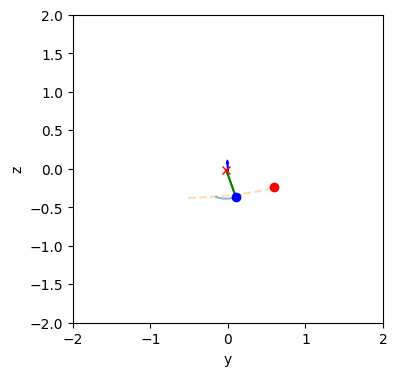

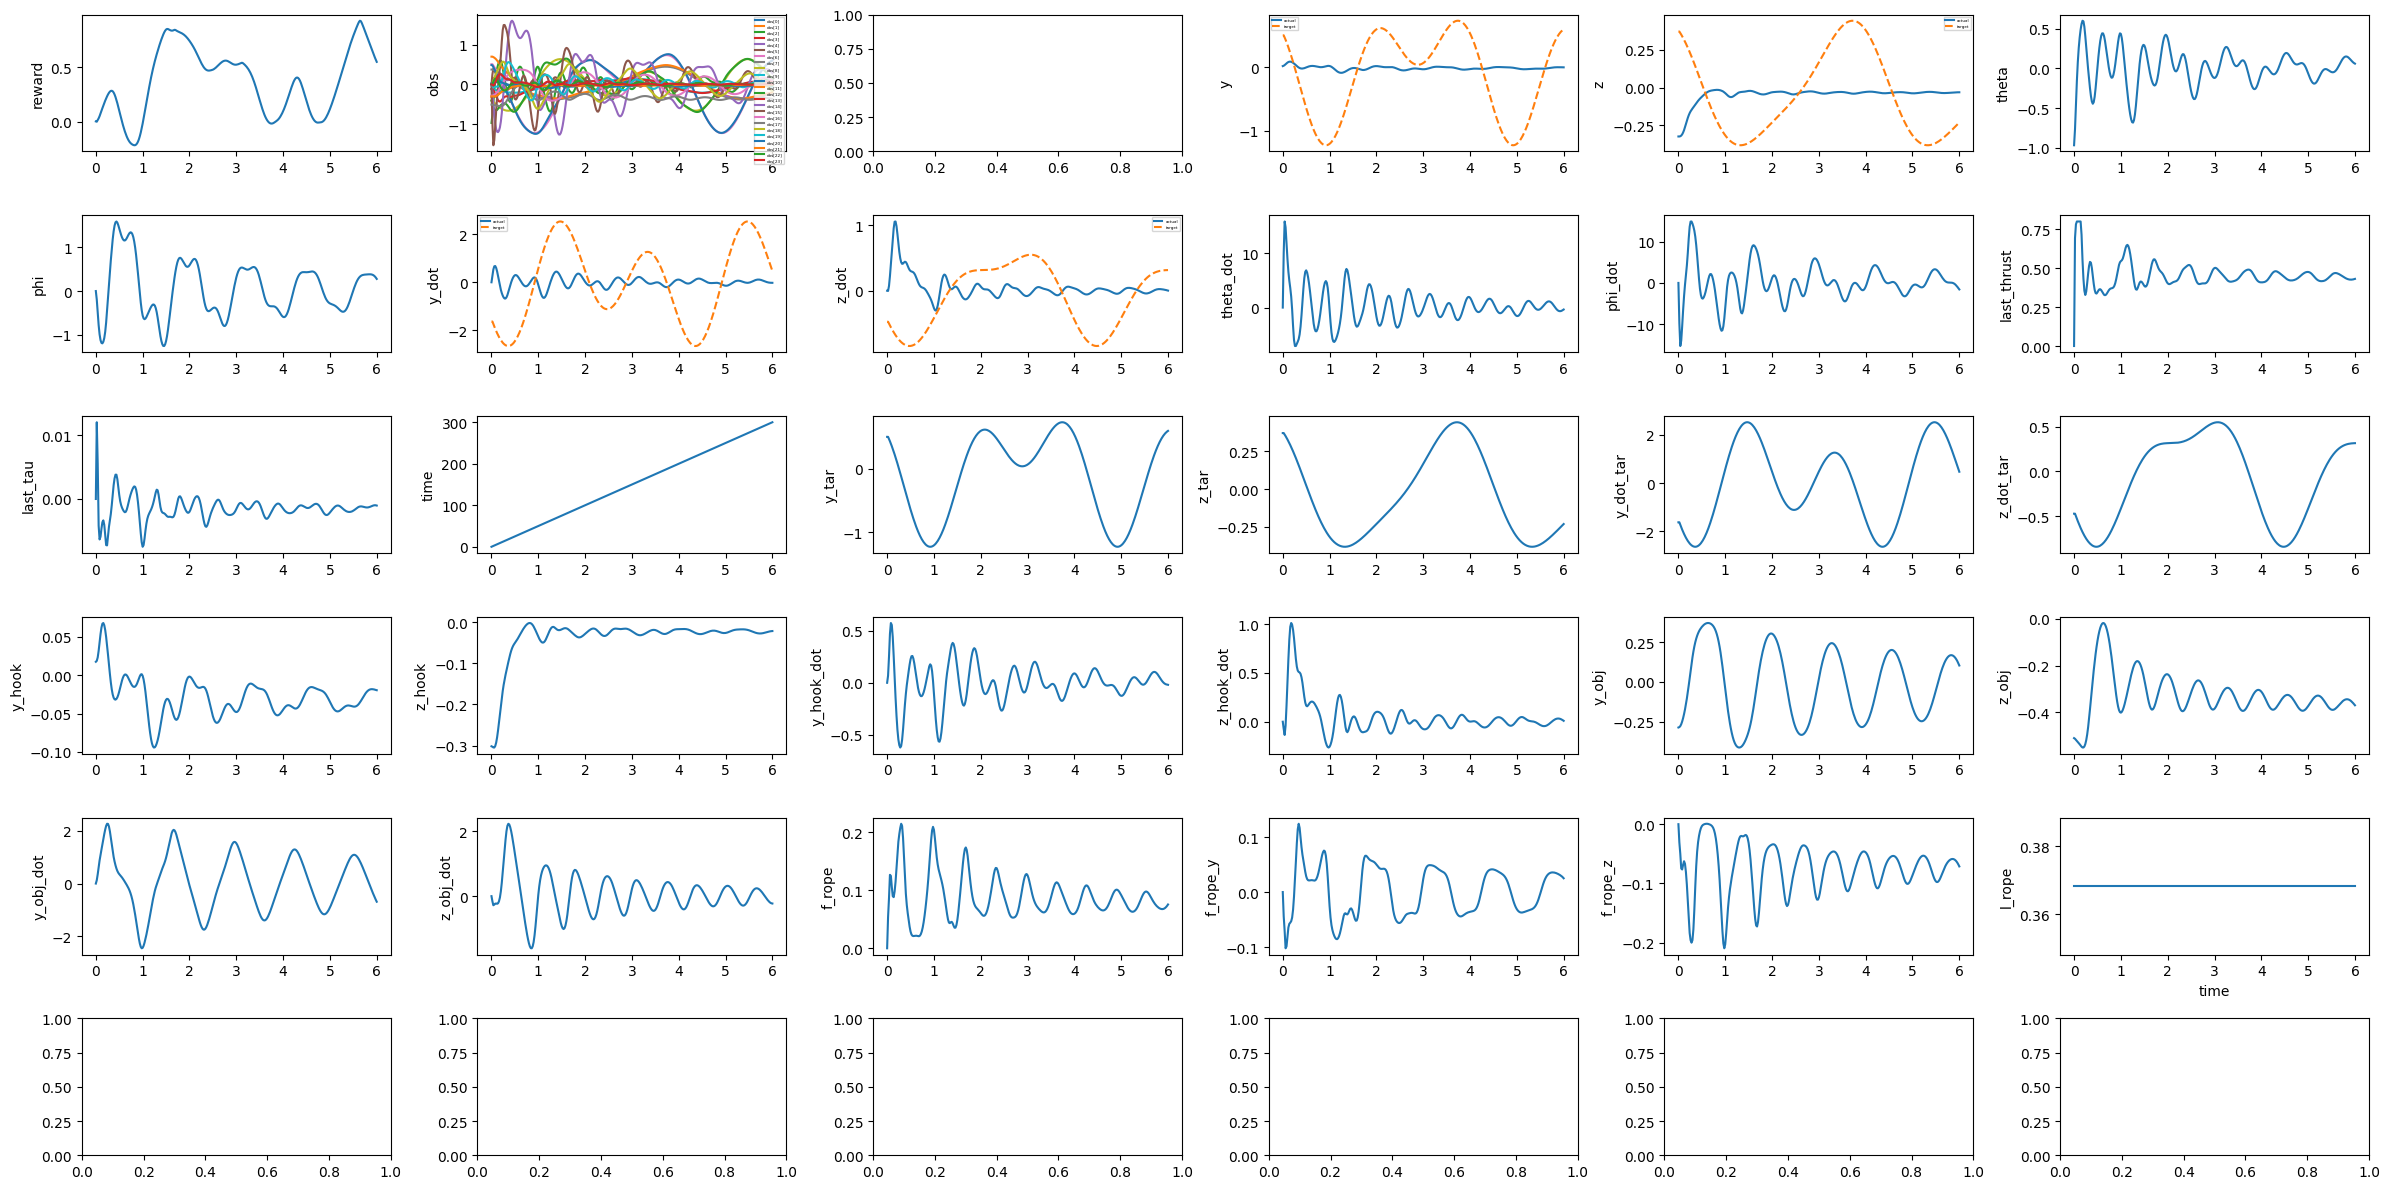

In [49]:
env = Quad2D()

random_policy = lambda obs, rng: env.action_space(env.default_params).sample(rng)

def pid_policy(obs, rng):
    y = obs[0]
    z = obs[1]
    theta = obs[2]
    y_dot = obs[3] * 4.0
    z_dot = obs[4] * 4.0
    theta_dot = obs[5] * 40.0
    y_tar = obs[6] * 0.0 # DEBUG
    z_tar = obs[7] * 0.0
    y_dot_tar = obs[8] * 4.0 * 0.0
    z_dot_tar = obs[9] * 4.0 * 0.0

    w0 = 10.0
    zeta = 0.95
    kp = env.default_params.m * (w0**2)
    kd = env.default_params.m * 2.0 * zeta * w0
    target_force_y = kp * (y_tar - y) + kd * (y_dot_tar - y_dot)
    target_force_z = (
        kp * (z_tar - z)
        + kd * (z_dot_tar - z_dot)
        + (env.default_params.m + env.default_params.mo) * env.default_params.g
    )
    thrust = -target_force_y * jnp.sin(theta) + target_force_z * jnp.cos(theta)
    target_theta = -jnp.arctan2(target_force_y, target_force_z)

    w0 = 30.0
    zeta = 0.95
    tau = env.default_params.I * (
        (w0**2) * (target_theta - theta) + 2.0 * zeta * w0 * (0.0 - theta_dot)
    )

    # convert into action space
    thrust_normed = jnp.clip(
        thrust / env.default_params.max_thrust * 2.0 - 1.0, -1.0, 1.0
    )
    tau_normed = jnp.clip(tau / env.default_params.max_torque, -1.0, 1.0)
    return jnp.array([thrust_normed, tau_normed])


# with jax.disable_jit():
test_env(env, policy=pid_policy, render_video=True)

## Training

### make training function

In [8]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from gymnax.environments import environment, spaces
from brax.envs.wrappers import training
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param('log_std', nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env= Quad2D()
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):
        # INIT ENV
        rng, rng1, rng2 = jax.random.split(rng, 3)
        reset_rng = jax.random.split(rng1, config["NUM_ENVS"])
        param_rng = jax.random.split(rng2, config["NUM_ENVS"])
        env_params = jax.vmap(env.sample_params)(param_rng)
        obsv, env_state = jax.vmap(env.reset)(reset_rng, env_params)

        # INIT NETWORK
        network = ActorCritic(env.action_space(env_params).shape[0], activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng, env_params = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step)(
                    rng_step, env_state, action, env_params
                )
                # resample environment parameters if done
                rng_params = jax.random.split(_rng, config["NUM_ENVS"])
                new_env_params = jax.vmap(env.sample_params)(rng_params)
                env_params = jax.tree_map(lambda x, y: jax.lax.select(done, x, y), new_env_params, env_params)

                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng, env_params)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng, env_params = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng, env_params)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng, env_params)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train

### training config

In [31]:
config = {
    "LR": 3e-4,
    "NUM_ENVS": 2048,
    "NUM_STEPS": 300,
    "TOTAL_TIMESTEPS": 2.0e7,
    "UPDATE_EPOCHS": 2,
    "NUM_MINIBATCHES": 320,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ANNEAL_LR": False,
}

### jit

In [32]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
train_jit = jax.jit(make_train(config))
print(f"jit time: {time.time() - t0:.2f} s")

jit time: 0.03 s


### train

train time: 38.77 s


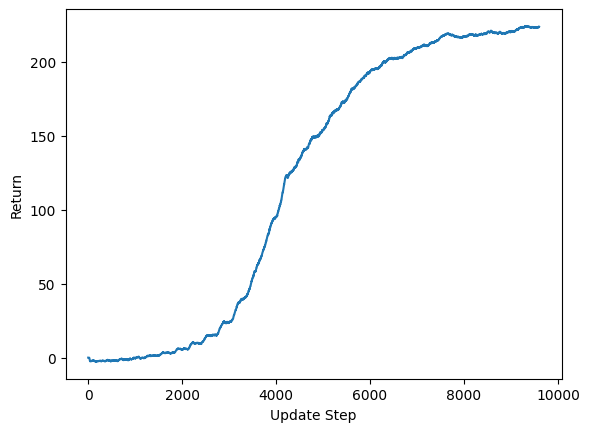

In [33]:
t0 = time.time()
out = jax.block_until_ready(train_jit(rng))
print(f"train time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

### save

In [34]:
# save network params
import pickle
with open("../results/ppo_params.pkl", "wb") as f:
    pickle.dump(out["runner_state"][0].params, f)

### evaluate

MovieWriter imagemagick unavailable; using Pillow instead.


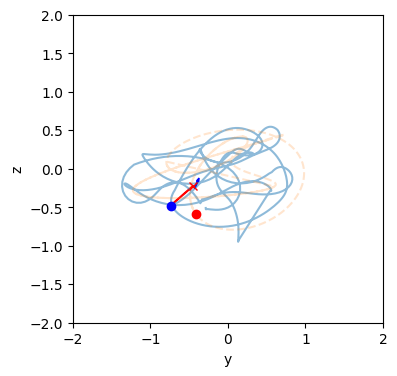

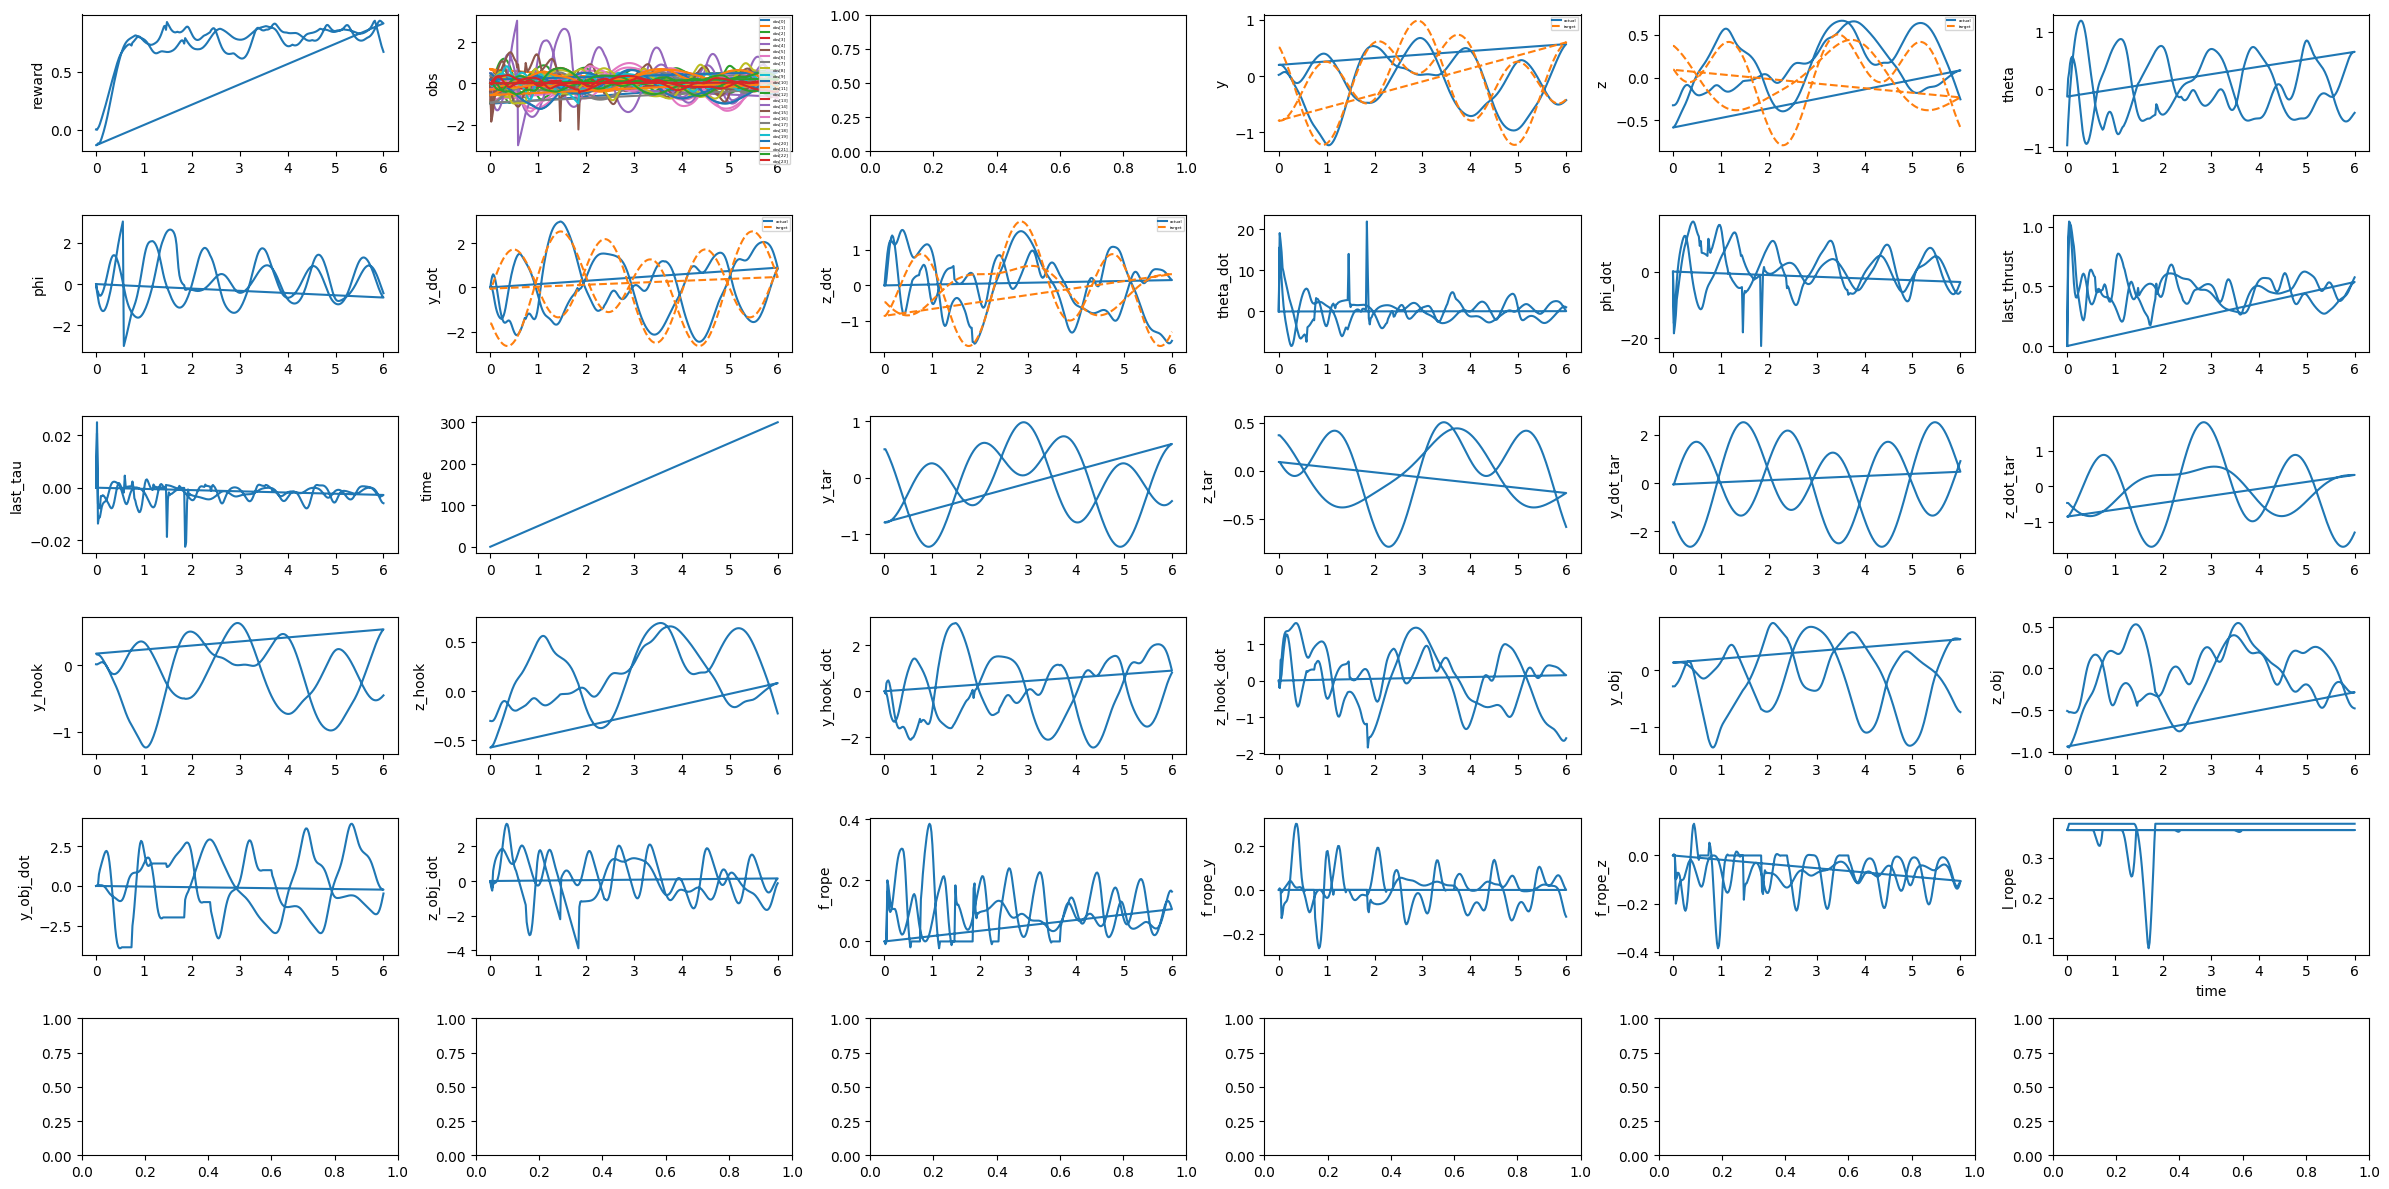

In [35]:
rng = jax.random.PRNGKey(1)
env = Quad2D()
apply_fn = out['runner_state'][0].apply_fn
params= out['runner_state'][0].params
def policy(obs, rng):
    return apply_fn(params, obs)[0].mean()
env.reset(rng)
# test policy
test_env(env, policy=policy, render_video=True)  